# Better Preserving Local Density with DensMAP

A notable assumption in UMAP is that the data is uniformly distributed on some manifold and that it is ultimately this manifold that we would like to present. This is highly effective for many use cases, but it can be the case that one would like to preserve more information about the relative local density of data. A recent paper presented a technique called [DensMAP](https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1) the computes estimates of the local density and uses those estimates as a regularizer in the optimization of the low dimensional representation. The details are well explained in [the paper](https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1) and we encourage those curious about the details to read it. The result is a low dimensional representation that preserves information about the relative local density of the data. To see what this means in practice let's load some modules and try it out on some familiar data.

In [1]:
import sklearn.datasets
import umap
import umap.plot

For test data we will make use of the now familiar (see earlier tutorial sections) MNIST and Fashion-MNIST datasets. MNIST is a collection of 70,000 gray-scale images of hand-written digits. Fashion-MNIST is a collection of 70,000 gray-scale images of fashion items.

In [2]:
mnist = sklearn.datasets.fetch_openml("mnist_784")
fmnist = sklearn.datasets.fetch_openml("Fashion-MNIST")

Before we try out DensMAP let's run standard UMAP so we have a baseline to compare to. We'll start with MNIST digits.

In [3]:
%%time
mapper = umap.UMAP(random_state=42).fit(mnist.data)

CPU times: user 2min, sys: 15 s, total: 2min 15s
Wall time: 1min 43s


<AxesSubplot:>

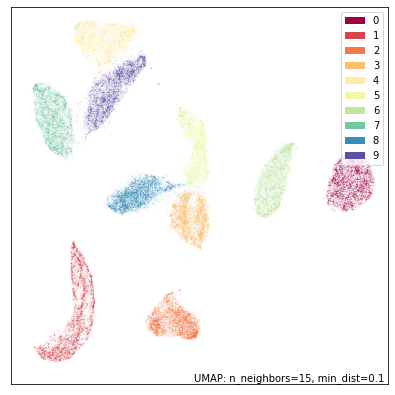

In [4]:
umap.plot.points(mapper, labels=mnist.target, width=500, height=500)

Now let's try running DensMAP instead. In practice this is as easy as adding the parameter ``densmap=True`` to the UMAP constructor -- this will cause UMAP use use DensMAP regularization with the default DensMAP parameters.

In [5]:
%%time
dens_mapper = umap.UMAP(densmap=True, random_state=42).fit(mnist.data)

CPU times: user 3min 42s, sys: 12.9 s, total: 3min 55s
Wall time: 2min 20s


Note that this is a little slower than standard UMAP -- there is a little more work to be done. It is worth noting, however, that the DensMAP overhead is relatively constant, so the difference in runtime won't increase much as you scale out DensMAP to larger datasets.

Now let's see what sort of results we get:

<AxesSubplot:>

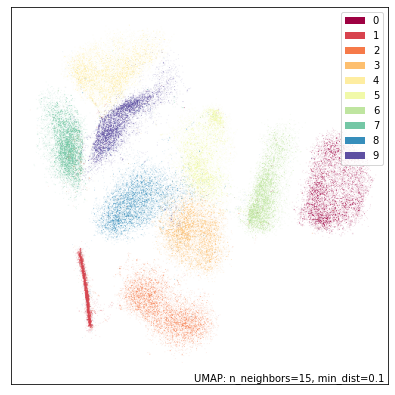

In [6]:
umap.plot.points(dens_mapper, labels=mnist.target, width=500, height=500)

This is a significantly different result -- although notably the same groupings of digits and overall structure have resulted. The most striking aspects are that the ones cluster has be compressed into a very narrow and dense stripe, while other digit clusters, most notably the zeros and the twos have expanded out to fill more space in the plot. This is due to the fact that in the high dimensional space the ones are indeed more densely packed together, with largely only variation along one dimension (the angle with which the stroke of the one is drawn). In contrast a digit like the zero has a lot more variation (rounder, narrower, taller, shorter, sloping one way or another); this results in less local density in high dimensional space, and this lack of local density has been preserved by DensMAP.

Let's no look at the Fashion-MNIST dataset; as before we'll start by reminding ourselves what the default UMAP results look like:

In [7]:
%%time
mapper = umap.UMAP(random_state=42).fit(fmnist.data)

CPU times: user 1min 6s, sys: 8.66 s, total: 1min 15s
Wall time: 49.8 s


<AxesSubplot:>

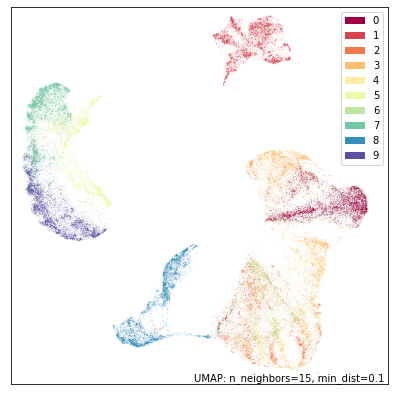

In [8]:
umap.plot.points(mapper, labels=fmnist.target, width=500, height=500)

Now let's try running DensMAP. As before that is as simple as setting the ``densmap=True`` flag.

In [9]:
%%time
dens_mapper = umap.UMAP(densmap=True, random_state=42).fit(fmnist.data)

CPU times: user 3min 48s, sys: 8.07 s, total: 3min 56s
Wall time: 2min 21s


<AxesSubplot:>

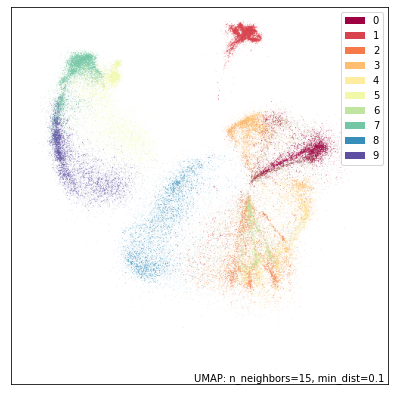

In [10]:
umap.plot.points(dens_mapper, labels=fmnist.target, width=500, height=500)

Again we see that DensMAP provides a plot similar to UMAP broadly, but with striking differences. Here we get to see that the cluster of bags (label 8 in blue) is actually quite sparse, while the cluster of pants (label 1 in red) is actually quite dense with little variation compared to other categories. We even see information internal to clusters. Consider the cluster of boots (label 9 in violet): at the top end it is quite dense, but it fades out into a much sparse region.

So far we have used DensMAP with default parameters, but the implementation provides several parameters for adjusting exactly how the local density regularisation is handled. We encourage readers to consult the paper for the details of the many parameters available. For general use the main parameter of interest is called ``dens_lambda`` and it controls how strongly the local density regularisation acts. Larger values of ``dens_lambda`` with make preserving the local density a priority over the the standard UMAP objective, while smaller values lean more towards classical UMAP. The default value is 2.0. Let's play with it a little so we can see the effects of varying it. To start we'll use a higher ``dens_lambda`` of 5.0:

In [11]:
%%time
dens_mapper = umap.UMAP(densmap=True, dens_lambda=5.0, random_state=42).fit(fmnist.data)

CPU times: user 3min 47s, sys: 5.04 s, total: 3min 52s
Wall time: 2min 18s


<AxesSubplot:>

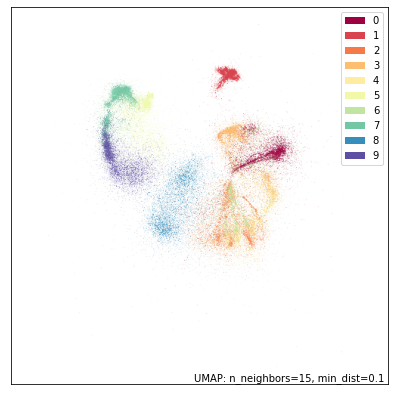

In [12]:
umap.plot.points(dens_mapper, labels=fmnist.target, width=500, height=500)

This looks kind of like what we had before, but blurrier. And also ...  smaller? The plot bounds are set by the data, so the fact that it is smaller represents the fact that there are some points right out to the edges of the plot. These are likely points that are in locally very sparse regions of the high dimensional space and are thus pushed well away from everything else. We can see this better if we use raw matplotlib and a scatter plot with larger point size: 

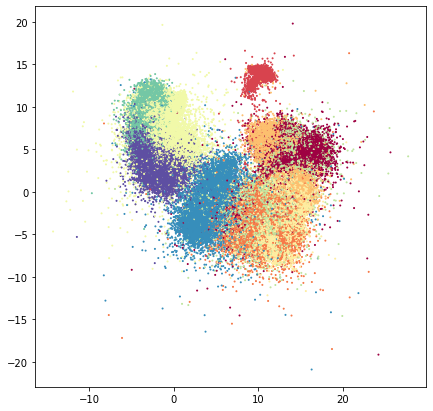

In [13]:
fig, ax = umap.plot.plt.subplots(figsize=(7,7))
ax.scatter(*dens_mapper.embedding_.T, c=fmnist.target.astype('int8'), cmap="Spectral", s=1)

Aside from seeing the issues with overplotting we can see that there are, in fact, quite a few points that create a very soft halo of of sparse points around the fringes.

Now let's try going the other way and reduce ``dens_lambda`` to a small value, so that in principle we can recover something quite close to the default UMAP plot, with just a hint of local density information encoded.

In [14]:
%%time
dens_mapper = umap.UMAP(densmap=True, dens_lambda=0.1, random_state=42).fit(fmnist.data)

CPU times: user 3min 47s, sys: 3.78 s, total: 3min 51s
Wall time: 2min 16s


<AxesSubplot:>

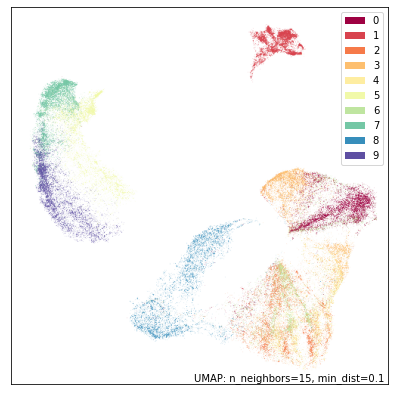

In [15]:
umap.plot.points(dens_mapper, labels=fmnist.target, width=500, height=500)

And indeed, this looks very much like the original plot, but the bags (label 8 in blue) are slightly more diffused, and the pants (label 1 in red) are a little denser. This is very much the default UMAP with just a tweak to better reflect some notion of local density.